런타임 유형 변경을 통해, GPU 세션으로 실행하는 것을 잊지 마십시오.

# 베이스 import

In [8]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

# Base libraries
import os
import random
import cv2

# Keras libraries
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from keras.layers import  Dropout, Activation
from keras.optimizers import Adam, SGD
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.utils import plot_model

print(tf.__version__)

2.3.0


# 유틸

In [9]:
def save_model(model_name: str, model: keras.models.Model):
    model_json = model.to_json()
    with open(model_name, "w") as json_file:
        json_file.write(model_json)

from keras.models import model_from_json
from typing import Optional

In [10]:
def load_model(
    model_name: str, with_weights_path: Optional[str] = None
) -> keras.models.Model:
    json_file = open(model_name, "r")
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    if with_weights_path:
        model.load_weights(with_weights_path)
    return model

In [11]:
# # 구글 드라이브 import
# from google.colab import drive
# drive.mount('/gdrive', force_remount=True)

# import os
# gdrive_path = os.path.join("/gdrive", "My Drive", "lecture", "resources")

# Dataset

## 다운로드

In [12]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xvzf images.tar.gz && tar -xvzf annotations.tar.gz
!rm  images/*.mat

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
annotations/trimaps/._pomeranian_180.png
annotations/trimaps/pomeranian_180.png
annotations/trimaps/._pomeranian_181.png
annotations/trimaps/pomeranian_181.png
annotations/trimaps/._pomeranian_182.png
annotations/trimaps/pomeranian_182.png
annotations/trimaps/._pomeranian_183.png
annotations/trimaps/pomeranian_183.png
annotations/trimaps/._pomeranian_184.png
annotations/trimaps/pomeranian_184.png
annotations/trimaps/._pomeranian_185.png
annotations/trimaps/pomeranian_185.png
annotations/trimaps/._pomeranian_186.png
annotations/trimaps/pomeranian_186.png
annotations/trimaps/._pomeranian_187.png
annotations/trimaps/pomeranian_187.png
annotations/trimaps/._pomeranian_188.png
annotations/trimaps/pomeranian_188.png
annotations/trimaps/._pomeranian_189.png
annotations/trimaps/pomeranian_189.png
annotations/trimaps/._pomeranian_19.png
annotations/trimaps/pomeranian_19.png
annotations/trimaps/._pomeranian_190.png
annotations/trimaps/pomeranian_190.png
annota

In [13]:
# cv2가 처리하지 못하는 파일 삭제

!rm -f images/Egyptian_Mau_177.jpg
!rm -f annotations/trimaps/Egyptian_Mau_177.png

!rm -f images/Egyptian_Mau_191.jpg
!rm -f annotations/trimaps/Egyptian_Mau_191.png

!rm -f images/Egyptian_Mau_139.jpg
!rm -f annotations/trimaps/Egyptian_Mau_139.png

!rm -f images/Egyptian_Mau_145.jpg
!rm -f annotations/trimaps/Egyptian_Mau_145.png

!rm -f images/Egyptian_Mau_167.jpg
!rm -f annotations/trimaps/Egyptian_Mau_167.png

!rm -f images/Abyssinian_34.jpg
!rm -f annotations/trimaps/Abyssinian_34.png

# list.txt에 존재하지 않음
!rm -f images/Egyptian_Mau_41.jpg
!rm -f annotations/trimaps/Egyptian_Mau_41.png

!rm -f images/Bombay_220.jpg
!rm -f annotations/trimaps/Bombay_220.png

!rm -f images/english_cocker_spaniel_163.jpg
!rm -f annotations/trimaps/english_cocker_spaniel_163.png

!rm -f images/Abyssinian_82.jpg
!rm -f annotations/trimaps/Abyssinian_82.png

!rm -f images/Bombay_189.jpg
!rm -f images/Bombay_69.jpg
!rm -f images/Bombay_209.jpg
!rm -f images/english_cocker_spaniel_164.jpg
!rm -f images/Siamese_203.jpg
!rm -f images/Egyptian_Mau_202.jpg
!rm -f images/keeshond_59.jpg
!rm -f images/newfoundland_154.jpg
!rm -f images/Bombay_92.jpg
!rm -f images/newfoundland_152.jpg
!rm -f images/Bombay_22.jpg
!rm -f images/Bombay_32.jpg
!rm -f images/Bombay_217.jpg
!rm -f images/Egyptian_Mau_183.jpg
!rm -f images/Egyptian_Mau_129.jpg
!rm -f images/Bombay_206.jpg
!rm -f images/newfoundland_153.jpg
!rm -f images/Bombay_192.jpg
!rm -f images/Egyptian_Mau_71.jpg
!rm -f images/Bombay_210.jpg
!rm -f images/Bombay_85.jpg
!rm -f images/Bombay_99.jpg
!rm -f images/staffordshire_bull_terrier_22.jpg
!rm -f images/boxer_82.jpg
!rm -f images/staffordshire_bull_terrier_2.jpg
!rm -f images/Bombay_11.jpg
!rm -f images/Bombay_190.jpg
!rm -f images/english_cocker_spaniel_162.jpg
!rm -f images/newfoundland_155.jpg
!rm -f images/english_cocker_spaniel_179.jpg
!rm -f images/Bombay_203.jpg




# 그 외 에러?
!rm -f images/Bengal_85.jpg
!rm -f annotations/trimaps/Bengal_85.png

!rm -f images/Egyptian_Mau_47.jpg
!rm -f annotations/trimaps/Egyptian_Mau_47.png

# 기초문제

## Semantic Segmentation

### 준비

In [24]:
batch_size = 32
seed = 42

In [25]:
image_files = os.listdir("images")
image_names = list(map(lambda v: v[:-4], image_files))

random.seed(seed)
random.shuffle(image_names)

split = int(0.95 * len(image_names))
train_image_names = image_names[0:split]
test_image_names  = image_names[split:]

val_split = int(0.9 * len(train_image_names))
val_image_names = train_image_names[val_split:]
train_image_names = train_image_names[0:val_split]

In [26]:
import toolz
import numpy as np

def img_mask_generator(img_path, mask_path, image_files, mask_files, batch_size=1, target_size=(256, 256)):
  total_file_num = len(image_files)
  index = -1
  while True:
    index = 0 if index > ((total_file_num // batch_size) - 2) else index+1
    img_batch = []
    mask_batch = []
    
    for i in range(batch_size):
      img = cv2.imread(os.path.join(img_path, image_files[batch_size*index+i]), cv2.IMREAD_COLOR)
      img = cv2.resize(img, target_size, interpolation=cv2.INTER_NEAREST)

      img = img / 255.

      img_batch.append(img)
      
      mask = cv2.imread(os.path.join(mask_path, mask_files[batch_size*index+i]), cv2.IMREAD_GRAYSCALE)
      mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)

      mask[mask >= 2] = 0
      mask[mask != 0] = 1
      
      mask = np.reshape(mask, (mask.shape[0], mask.shape[1], 1))
      mask_batch.append(mask)

    yield np.array(img_batch), np.array(mask_batch)

with_ext = lambda v, ext: "{}.{}".format(v, ext)

In [27]:
train_batch_generator = img_mask_generator(
    img_path=os.path.join("images"),
    mask_path=os.path.join("annotations", "trimaps"),
    image_files=list(map(lambda v: with_ext(v, "jpg"), train_image_names)),
    mask_files=list(map(lambda v: with_ext(v, "png"), train_image_names)),
    batch_size=batch_size,
    target_size=(256, 256))

val_batch_generator = img_mask_generator(
    img_path=os.path.join("images"),
    mask_path=os.path.join("annotations", "trimaps"),
    image_files=list(map(lambda v: with_ext(v, "jpg"), val_image_names)),
    mask_files=list(map(lambda v: with_ext(v, "png"), val_image_names)),
    batch_size=batch_size,
    target_size=(256, 256))

test_batch_generator = img_mask_generator(
    img_path=os.path.join("images"),
    mask_path=os.path.join("annotations", "trimaps"),
    image_files=list(map(lambda v: with_ext(v, "jpg"), test_image_names)),
    mask_files=list(map(lambda v: with_ext(v, "png"), test_image_names)),
    batch_size=batch_size,
    target_size=(256, 256))

In [28]:
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.math.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

### 문제1. 다음의 U-Net 모델을 완성시키세요.

* (가산) optimizer, 필터 및 구조를 바꾸어가며, 높은 mean iou를 달성하도록 시도하십시오.
* 더 높은 mean iou를 달성하기 위해, 위에서 제시하는 모든 함수를 바꾸어도 됩니다.
* (기본) 내용을 따라오지 못했다면, 기존의 코드를 복사해 제출합니다.

In [52]:
def unet(input_size = (256, 256, 3)):
    x = Input(input_size)
    inputs=x
    # down sampling 
    f = 8
    layers = []
    
    for i in range(0, 6):
      x = Conv2D(f, 3, activation='relu', padding='same') (x)
      x = Conv2D(f, 3, activation='relu', padding='same') (x)
      layers.append(x)
      x = MaxPooling2D() (x)
      f = f*2
    ff2 = 64 
    
    # bottleneck 
    j = len(layers) - 1
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
    x = Concatenate(axis=3)([x, layers[j]])
    j = j -1 
    
    # upsampling 
    for i in range(0, 5):
      ff2 = ff2//2
      f = f // 2 
      x = Conv2D(f, 3, activation='relu', padding='same') (x)
      x = Conv2D(f, 3, activation='relu', padding='same') (x)
      x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
      x = Concatenate(axis=3)([x, layers[j]])
      j = j -1 
      
    
    # classification 
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)

    outputs = Conv2D(1, 1, activation='sigmoid') (x)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = [mean_iou])
  
    return model

### 실행

In [53]:
model = unet()
model.summary()

Model: "functional_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_87 (Conv2D)              (None, 256, 256, 8)  224         input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_88 (Conv2D)              (None, 256, 256, 8)  584         conv2d_87[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_20 (MaxPooling2D) (None, 128, 128, 8)  0           conv2d_88[0][0]                  
______________________________________________________________________________________

In [54]:
def build_callbacks():
        checkpointer = ModelCheckpoint(filepath='unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
        callbacks = [checkpointer, PlotLearning()]
        return callbacks

val_image_list = list(map(lambda v: with_ext(v, "jpg"), val_image_names))

# inheritance for training process plot 
class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        #self.fig = plt.figure()
        self.logs = []
        
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('mean_iou'))
        self.val_acc.append(logs.get('val_mean_iou'))
        self.i += 1
        # print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),'mean_iou=',logs.get('mean_iou'),'val_mean_iou=',logs.get('val_mean_iou'))
        
        # choose a random test image and preprocess
        path = np.random.choice(val_image_list)
        img = cv2.imread(f'images/{path}')
        img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_NEAREST)
        img = img / 255.

        target_mask = cv2.imread(os.path.join("annotations", "trimaps", "{}.png".format(path[:-4])))
        target_mask = cv2.resize(target_mask, (256, 256), interpolation=cv2.INTER_NEAREST)
        target_mask[target_mask >= 2] = 0
        target_mask[target_mask != 0] = 1
        
        # predict the mask 
        pred = model.predict(np.expand_dims(img, 0))
        
        # mask post-processing 
        msk = pred.squeeze()
        msk = np.stack((msk,)*3, axis=-1)
        msk[msk >= 0.5] = 1 
        msk[msk < 0.5] = 0 
        
        # show the mask and the segmented image 
        img = img.astype(np.float32) 
        rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        combined = np.concatenate([rgb_img, msk, rgb_img * msk, target_mask], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()

Epoch 1/20
196/196 [==============================] - ETA: 0s - loss: 0.5472 - mean_iou: 0.1722

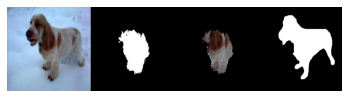

196/196 [==============================] - 52s 267ms/step - loss: 0.5472 - mean_iou: 0.1722 - val_loss: 0.4518 - val_mean_iou: 0.3582
Epoch 2/20
196/196 [==============================] - ETA: 0s - loss: 0.4386 - mean_iou: 0.4383

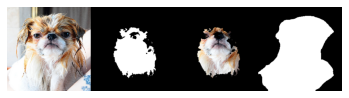

196/196 [==============================] - 52s 266ms/step - loss: 0.4386 - mean_iou: 0.4383 - val_loss: 0.4088 - val_mean_iou: 0.4478
Epoch 3/20
196/196 [==============================] - ETA: 0s - loss: 0.4119 - mean_iou: 0.4780

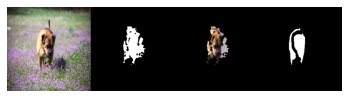

196/196 [==============================] - 51s 263ms/step - loss: 0.4119 - mean_iou: 0.4780 - val_loss: 0.3809 - val_mean_iou: 0.5036
Epoch 4/20
196/196 [==============================] - ETA: 0s - loss: 0.3674 - mean_iou: 0.5509

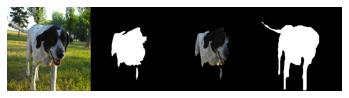

196/196 [==============================] - 52s 263ms/step - loss: 0.3674 - mean_iou: 0.5509 - val_loss: 0.3242 - val_mean_iou: 0.5840
Epoch 5/20
196/196 [==============================] - ETA: 0s - loss: 0.3188 - mean_iou: 0.6142

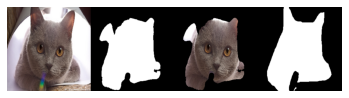

196/196 [==============================] - 51s 261ms/step - loss: 0.3188 - mean_iou: 0.6142 - val_loss: 0.3142 - val_mean_iou: 0.6151
Epoch 6/20
196/196 [==============================] - ETA: 0s - loss: 0.2819 - mean_iou: 0.6584

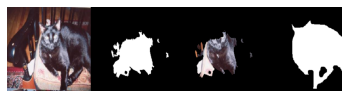

196/196 [==============================] - 51s 261ms/step - loss: 0.2819 - mean_iou: 0.6584 - val_loss: 0.2893 - val_mean_iou: 0.6547
Epoch 7/20
196/196 [==============================] - ETA: 0s - loss: 0.2589 - mean_iou: 0.6849

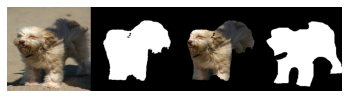

196/196 [==============================] - 51s 262ms/step - loss: 0.2589 - mean_iou: 0.6849 - val_loss: 0.2518 - val_mean_iou: 0.6901
Epoch 8/20
196/196 [==============================] - ETA: 0s - loss: 0.2360 - mean_iou: 0.7133

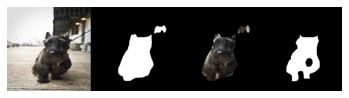

196/196 [==============================] - 52s 265ms/step - loss: 0.2360 - mean_iou: 0.7133 - val_loss: 0.2387 - val_mean_iou: 0.7201
Epoch 9/20
196/196 [==============================] - ETA: 0s - loss: 0.2231 - mean_iou: 0.7295

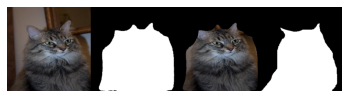

196/196 [==============================] - 52s 267ms/step - loss: 0.2231 - mean_iou: 0.7295 - val_loss: 0.2278 - val_mean_iou: 0.7329
Epoch 10/20
196/196 [==============================] - ETA: 0s - loss: 0.2186 - mean_iou: 0.7341

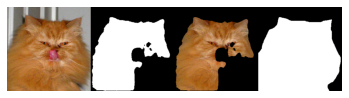

196/196 [==============================] - 52s 268ms/step - loss: 0.2186 - mean_iou: 0.7341 - val_loss: 0.2362 - val_mean_iou: 0.7261
Epoch 11/20
196/196 [==============================] - ETA: 0s - loss: 0.1985 - mean_iou: 0.7566

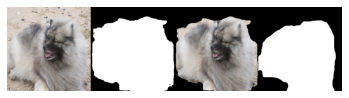

196/196 [==============================] - 53s 269ms/step - loss: 0.1985 - mean_iou: 0.7566 - val_loss: 0.2270 - val_mean_iou: 0.7348
Epoch 12/20
196/196 [==============================] - ETA: 0s - loss: 0.1876 - mean_iou: 0.7696

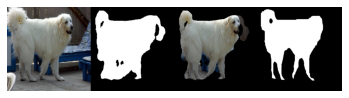

196/196 [==============================] - 52s 267ms/step - loss: 0.1876 - mean_iou: 0.7696 - val_loss: 0.2276 - val_mean_iou: 0.7349
Epoch 13/20
196/196 [==============================] - ETA: 0s - loss: 0.1796 - mean_iou: 0.7797

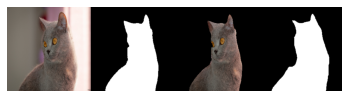

196/196 [==============================] - 53s 268ms/step - loss: 0.1796 - mean_iou: 0.7797 - val_loss: 0.2190 - val_mean_iou: 0.7379
Epoch 14/20
196/196 [==============================] - ETA: 0s - loss: 0.1718 - mean_iou: 0.7884

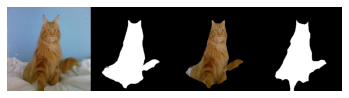

196/196 [==============================] - 53s 270ms/step - loss: 0.1718 - mean_iou: 0.7884 - val_loss: 0.2317 - val_mean_iou: 0.7391
Epoch 15/20
196/196 [==============================] - ETA: 0s - loss: 0.1739 - mean_iou: 0.7864

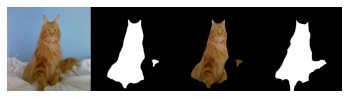

196/196 [==============================] - 52s 267ms/step - loss: 0.1739 - mean_iou: 0.7864 - val_loss: 0.2356 - val_mean_iou: 0.7275
Epoch 16/20
196/196 [==============================] - ETA: 0s - loss: 0.1642 - mean_iou: 0.7978

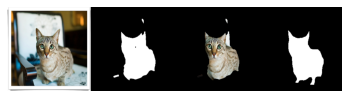

196/196 [==============================] - 53s 269ms/step - loss: 0.1642 - mean_iou: 0.7978 - val_loss: 0.2474 - val_mean_iou: 0.7178
Epoch 17/20
196/196 [==============================] - ETA: 0s - loss: 0.1564 - mean_iou: 0.8059

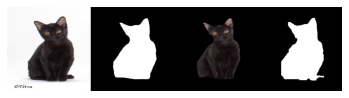

196/196 [==============================] - 53s 270ms/step - loss: 0.1564 - mean_iou: 0.8059 - val_loss: 0.2689 - val_mean_iou: 0.6919
Epoch 18/20
196/196 [==============================] - ETA: 0s - loss: 0.1585 - mean_iou: 0.8037

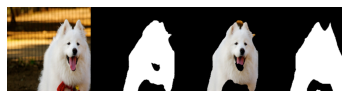

196/196 [==============================] - 53s 270ms/step - loss: 0.1585 - mean_iou: 0.8037 - val_loss: 0.2431 - val_mean_iou: 0.7228
Epoch 19/20
196/196 [==============================] - ETA: 0s - loss: 0.1476 - mean_iou: 0.8167

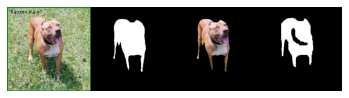

196/196 [==============================] - 53s 271ms/step - loss: 0.1476 - mean_iou: 0.8167 - val_loss: 0.2118 - val_mean_iou: 0.7613
Epoch 20/20
196/196 [==============================] - ETA: 0s - loss: 0.1434 - mean_iou: 0.8213

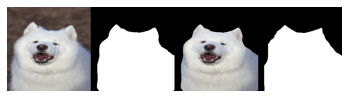

196/196 [==============================] - 53s 272ms/step - loss: 0.1434 - mean_iou: 0.8213 - val_loss: 0.2219 - val_mean_iou: 0.7635


In [55]:
train_steps = len(train_image_names) // batch_size
val_steps = len(val_image_names) // batch_size

history = model.fit(
    train_batch_generator,
    epochs = 20,
    steps_per_epoch = train_steps,
    validation_data = val_batch_generator, 
    validation_steps = val_steps,
    callbacks = build_callbacks(), 
    verbose = 1)

In [56]:
test_steps = len(test_image_names) // batch_size
test_loss, test_mean_iou = model.evaluate(test_batch_generator, steps=test_steps, verbose=2)
print('테스트 정확도:', test_mean_iou)

11/11 - 2s - loss: 0.2251 - mean_iou: 0.7652
테스트 정확도: 0.7652300000190735


## Classification

### 준비

In [44]:
fashion_mnist = keras.datasets.fashion_mnist

(fashion_train_images, fashion_train_labels), (fashion_test_images, fashion_test_labels) = fashion_mnist.load_data()

fashion_class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

fashion_train_images = fashion_train_images / 255.0
fashion_test_images = fashion_test_images / 255.0               

4423680/4422102 [==============================] - 0s 0us/step


In [45]:
fashion_train_labels.shape

fashion_train_labels[0]

9

### 문제2. 다음의 CNN 기반 Classification을 완성시키세요.

* (가산) optimizer, 필터 및 구조를 바꾸어가며, 높은 accuracy를 달성하도록 시도하십시오.
* (기본) 내용을 따라오지 못했다면, 기존의 코드를 복사해 제출합니다.

In [47]:
def cnn_classification_model():
  input = keras.layers.Input((28, 28, 1))

  conv_1 = keras.layers.Conv2D(6, 3, activation='relu', padding='same')(input)
  conv_1 = keras.layers.Conv2D(6, 3, activation='relu', padding='same')(conv_1)
  pool_1 = keras.layers.MaxPooling2D((2, 2), strides=2)(conv_1)

  conv_3 = keras.layers.Conv2D(16, 3, activation='relu', padding='same')(pool_1)
  conv_3 = keras.layers.Conv2D(16, 3, activation='relu', padding='same')(conv_3)
  pool_2 = keras.layers.MaxPooling2D((2, 2), strides=2)(conv_3)

  flatten = keras.layers.Flatten()(pool_2)
  dense_1 = keras.layers.Dense(120)(flatten)
  dense_2 = keras.layers.Dense(84)(dense_1)
  dense_3 = keras.layers.Dense(10, activation='softmax')(dense_2)

  return keras.models.Model(inputs=[input], outputs=[dense_3])

### 실행

In [48]:
classification_model = cnn_classification_model()

In [49]:
classification_model.compile(optimizer=keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [50]:
BATCH_SIZE = 32
fashion_num_train_examples = len(fashion_train_images)

import math

fashion_history = classification_model.fit(fashion_train_images, fashion_train_labels, epochs=10, batch_size=BATCH_SIZE, steps_per_epoch=math.ceil(fashion_num_train_examples/BATCH_SIZE))

Epoch 1/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.4512 - accuracy: 0.8353
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3065 - accuracy: 0.8887
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2715 - accuracy: 0.9010
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2528 - accuracy: 0.9077
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2394 - accuracy: 0.9122
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2268 - accuracy: 0.9157
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2205 - accuracy: 0.9187
Epoch 8/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2109 - accuracy: 0.9219
Epoch 9/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2032 - accuracy: 0.9250
Epoch 10/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.198

In [51]:
fashion_test_loss, fashion_test_acc = classification_model.evaluate(fashion_test_images, fashion_test_labels, verbose=2)
print('테스트 정확도:', fashion_test_acc)

313/313 - 1s - loss: 0.2670 - accuracy: 0.9080
테스트 정확도: 0.9079999923706055


# 심화문제

### 준비

In [57]:
image_files = os.listdir("images")
image_names = list(map(lambda v: v[:-4], image_files))

random.seed(seed)
random.shuffle(image_names)

split = int(0.95 * len(image_names))
train_image_names = image_names[0:split]
test_image_names  = image_names[split:]

val_split = int(0.9 * len(train_image_names))
val_image_names = train_image_names[val_split:]
train_image_names = train_image_names[0:val_split]

In [ ]:
# for i_n in image_names:
#   try:
#     q3_dict[i_n]
#   except:
#     print(i_n)
#   # q3_dict[i_n]

In [58]:
q3_text_file = open("annotations/list.txt", "r")
q3_lines = q3_text_file.readlines()
print(q3_lines)
print(len(q3_lines))
q3_text_file.close()

q3_text_file_remove_comment = list(filter(lambda v: v[0] != "#", q3_lines))
q3_text_file_remove_comment2 = list(map(lambda v: v.split(" "), q3_text_file_remove_comment))
q3_text_file_remove_comment3 = list(map(lambda v: (v[0], (int(v[2])-1)), q3_text_file_remove_comment2))
q3_dict = dict(q3_text_file_remove_comment3)

['#Image CLASS-ID SPECIES BREED ID\n', '#ID: 1:37 Class ids\n', '#SPECIES: 1:Cat 2:Dog\n', '#BREED ID: 1-25:Cat 1:12:Dog\n', '#All images with 1st letter as captial are cat images\n', '#images with small first letter are dog images\n', 'Abyssinian_100 1 1 1\n', 'Abyssinian_101 1 1 1\n', 'Abyssinian_102 1 1 1\n', 'Abyssinian_103 1 1 1\n', 'Abyssinian_104 1 1 1\n', 'Abyssinian_105 1 1 1\n', 'Abyssinian_106 1 1 1\n', 'Abyssinian_107 1 1 1\n', 'Abyssinian_108 1 1 1\n', 'Abyssinian_109 1 1 1\n', 'Abyssinian_10 1 1 1\n', 'Abyssinian_110 1 1 1\n', 'Abyssinian_111 1 1 1\n', 'Abyssinian_112 1 1 1\n', 'Abyssinian_113 1 1 1\n', 'Abyssinian_114 1 1 1\n', 'Abyssinian_115 1 1 1\n', 'Abyssinian_116 1 1 1\n', 'Abyssinian_117 1 1 1\n', 'Abyssinian_118 1 1 1\n', 'Abyssinian_119 1 1 1\n', 'Abyssinian_11 1 1 1\n', 'Abyssinian_120 1 1 1\n', 'Abyssinian_121 1 1 1\n', 'Abyssinian_122 1 1 1\n', 'Abyssinian_123 1 1 1\n', 'Abyssinian_124 1 1 1\n', 'Abyssinian_125 1 1 1\n', 'Abyssinian_126 1 1 1\n', 'Abyssinian_

In [59]:
import toolz
import numpy as np

def img_mask_species_generator(dd, img_path, mask_path, image_files, mask_files, batch_size=1, target_size=(256, 256)):
  total_file_num = len(image_files)
  index = -1
  while True:
    index = 0 if index > ((total_file_num // batch_size) - 2) else index+1
    img_batch = []
    mask_batch = []
    classify_batch = []
    
    for i in range(batch_size):
      img = cv2.imread(os.path.join(img_path, image_files[batch_size*index+i]), cv2.IMREAD_COLOR)
      img = cv2.resize(img, target_size, interpolation=cv2.INTER_NEAREST)

      img = img / 255.

      img_batch.append(img)
      
      mask = cv2.imread(os.path.join(mask_path, mask_files[batch_size*index+i]), cv2.IMREAD_GRAYSCALE)
      mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)

      mask[mask >= 2] = 0
      mask[mask != 0] = 1
      
      mask = np.reshape(mask, (mask.shape[0], mask.shape[1], 1))
      mask_batch.append(mask)

      classify_batch.append(dd[image_files[batch_size*index+i][:-4]])

    yield [np.array(img_batch)], [np.array(mask_batch), np.array(classify_batch).astype(np.float64)]

with_ext = lambda v, ext: "{}.{}".format(v, ext)

In [60]:
np.array(1).astype(np.float32)

array(1., dtype=float32)

In [ ]:
# x = np.array([1, 2, 3, 4, 5])
# ii = cv2.imread(os.path.join("images", "scottish_terrier_133.jpg"))
# cv2.resize(ii, (256, 256), interpolation=cv2.INTER_NEAREST)
# cv2.imread(os.path.join("annotations", "trimaps", "scottish_terrier_133.png"))

In [61]:
q3_train_batch_generator = img_mask_species_generator(
    q3_dict,
    img_path=os.path.join("images"),
    mask_path=os.path.join("annotations", "trimaps"),
    image_files=list(map(lambda v: with_ext(v, "jpg"), train_image_names)),
    mask_files=list(map(lambda v: with_ext(v, "png"), train_image_names)),
    batch_size=batch_size,
    target_size=(256, 256))

q3_val_batch_generator = img_mask_species_generator(
    q3_dict,
    img_path=os.path.join("images"),
    mask_path=os.path.join("annotations", "trimaps"),
    image_files=list(map(lambda v: with_ext(v, "jpg"), val_image_names)),
    mask_files=list(map(lambda v: with_ext(v, "png"), val_image_names)),
    batch_size=batch_size,
    target_size=(256, 256))

q3_test_batch_generator = img_mask_species_generator(
    q3_dict,
    img_path=os.path.join("images"),
    mask_path=os.path.join("annotations", "trimaps"),
    image_files=list(map(lambda v: with_ext(v, "jpg"), test_image_names)),
    mask_files=list(map(lambda v: with_ext(v, "png"), test_image_names)),
    batch_size=batch_size,
    target_size=(256, 256))

## 문제3. Classification + Semantic Segmentation

* 모델을 완성하십시오.
* optimizer, 필터 및 구조를 바꾸어가며, 높은 accuracy를 달성하도록 시도하십시오.
* 아래의 실행 부분에서, 손실 함수 및 가중치를 바꾸어가며, 높은 정확도를 달성하도록 시도하십시오.

```python
losses = {
	"model_seg_output": "binary_crossentropy",
	"model_classify_output": "sparse_categorical_crossentropy",
}
loss_weights = {"model_seg_output": 1.0, "model_classify_output": 1.0}
```


In [62]:
def classify_seg_model(input_size = (256, 256, 3)):
    x = Input(input_size)
    inputs = x

    # segmetation
    # down sampling 
    f = 8
    layers = []
    
    for i in range(0, 6):
      x = Conv2D(f, 3, activation='relu', padding='same') (x)
      x = Conv2D(f, 3, activation='relu', padding='same') (x)
      layers.append(x)
      x = MaxPooling2D() (x)
      f = f*2
    ff2 = 64 
    
    # bottleneck 
    j = len(layers) - 1
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
    x = Concatenate(axis=3)([x, layers[j]])
    j = j -1 
    
    # upsampling 
    for i in range(0, 5):
      ff2 = ff2//2
      f = f // 2 
      x = Conv2D(f, 3, activation='relu', padding='same') (x)
      x = Conv2D(f, 3, activation='relu', padding='same') (x)
      x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
      x = Concatenate(axis=3)([x, layers[j]])
      j = j -1 
      
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    seg_output = Conv2D(1, 1, activation='sigmoid', name="model_seg_output") (x)

    # classification 
    # pool_1 = keras.layers.MaxPooling2D((8, 8))(inputs)
    conv_1 = keras.layers.Conv2D(6, 3, activation='relu', padding='same')(inputs)
    conv_1 = keras.layers.Conv2D(6, 3, activation='relu', padding='same')(conv_1)
    pool_1 = keras.layers.MaxPooling2D((2, 2), strides=2)(conv_1)

    conv_3 = keras.layers.Conv2D(16, 3, activation='relu', padding='same')(pool_1)
    conv_3 = keras.layers.Conv2D(16, 3, activation='relu', padding='same')(conv_3)
    pool_2 = keras.layers.MaxPooling2D((2, 2), strides=2)(conv_3)

    flatten = keras.layers.Flatten()(pool_2)
    dense_1 = keras.layers.Dense(120)(flatten)
    dense_2 = keras.layers.Dense(84)(dense_1)
    dense_3 = keras.layers.Dense(10)(dense_2)
    classify_output = keras.layers.Dense(2, activation='softmax', name="model_classify_output")(dense_3)

    model = Model(inputs=[inputs], outputs=[seg_output, classify_output])
    return model

## 실행

In [63]:
cs_model = classify_seg_model()
cs_model.summary()

Model: "functional_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_114 (Conv2D)             (None, 256, 256, 8)  224         input_8[0][0]                    
__________________________________________________________________________________________________
conv2d_115 (Conv2D)             (None, 256, 256, 8)  584         conv2d_114[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_26 (MaxPooling2D) (None, 128, 128, 8)  0           conv2d_115[0][0]                 
______________________________________________________________________________________

In [64]:
losses = {
	"model_seg_output": "binary_crossentropy",
	"model_classify_output": "sparse_categorical_crossentropy",
}
loss_weights = {"model_seg_output": 1.0, "model_classify_output": 1.0}

cs_model.compile(optimizer=keras.optimizers.Adam(),
              loss=losses,
              loss_weights=loss_weights,
              metrics=['accuracy'])

In [65]:
q3_train_steps = len(train_image_names) // batch_size
q3_val_steps = len(val_image_names) // batch_size

q3_history = cs_model.fit(
    q3_train_batch_generator,
    epochs = 10,
    steps_per_epoch = q3_train_steps,
    validation_data = q3_val_batch_generator, 
    validation_steps = q3_val_steps,
    verbose = 1)

Epoch 1/10
196/196 [==============================] - 56s 284ms/step - loss: 1.3581 - model_seg_output_loss: 0.5175 - model_classify_output_loss: 0.8406 - model_seg_output_accuracy: 0.7320 - model_classify_output_accuracy: 0.6744 - val_loss: 0.9917 - val_model_seg_output_loss: 0.4240 - val_model_classify_output_loss: 0.5677 - val_model_seg_output_accuracy: 0.7978 - val_model_classify_output_accuracy: 0.7351
Epoch 2/10
196/196 [==============================] - 55s 279ms/step - loss: 0.9296 - model_seg_output_loss: 0.4231 - model_classify_output_loss: 0.5065 - model_seg_output_accuracy: 0.8019 - model_classify_output_accuracy: 0.7479 - val_loss: 0.9474 - val_model_seg_output_loss: 0.3947 - val_model_classify_output_loss: 0.5527 - val_model_seg_output_accuracy: 0.8180 - val_model_classify_output_accuracy: 0.7307
Epoch 3/10
196/196 [==============================] - 55s 279ms/step - loss: 0.7749 - model_seg_output_loss: 0.3997 - model_classify_output_loss: 0.3752 - model_seg_output_accura

In [66]:
test_steps = len(test_image_names) // batch_size
test_total_loss, test_seg_loss, test_classify_loss, test_seg_acc, test_classify_acc = cs_model.evaluate(q3_test_batch_generator, steps=test_steps, verbose=2)
print('테스트 정확도:', test_seg_acc, test_classify_acc)

11/11 - 2s - loss: 2.5459 - model_seg_output_loss: 0.2571 - model_classify_output_loss: 2.2887 - model_seg_output_accuracy: 0.9000 - model_classify_output_accuracy: 0.7216
테스트 정확도: 0.8999897241592407 0.7215909361839294


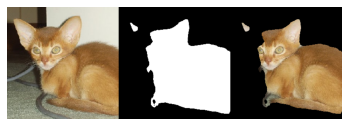

예측: 0
[[0.9501857  0.04981428]]
정답 :0


In [78]:
img_name = "Abyssinian_131.jpg"

img = cv2.imread(os.path.join("images", img_name))
img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_NEAREST)
img = img / 255.

# predict the mask 
pred = cs_model.predict(np.expand_dims(img, 0))

# mask post-processing 
msk = pred[0].squeeze()
msk = np.stack((msk,)*3, axis=-1)
msk[msk >= 0.5] = 1 
msk[msk < 0.5] = 0 

# show the mask and the segmented image
img = img.astype(np.float32) 
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
combined = np.concatenate([rgb_img, msk, rgb_img * msk], axis = 1)
plt.axis('off')
plt.imshow(combined)
plt.show()

# 0:Cat 1:Dog
print("예측: {}".format(np.argmax(pred[1])))
print(pred[1])
print("정답 :{}".format(q3_dict[img_name[:-4]]))

In [79]:
msk

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)